# Import modules

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from imblearn.combine import SMOTETomek

# Load Data

In [2]:
df = pd.read_csv('secom_clean.csv')
X = df.drop('target', axis=1)
y = df['target']


# Redefine Resampler & Model

In [3]:
print("Resampling data for Feature Selection...")
smt = SMOTETomek(random_state=42)
X_res, y_res = smt.fit_resample(X, y)

Resampling data for Feature Selection...


# Define Model

In [4]:
model = LogisticRegression(solver='liblinear', max_iter=2000)

# Feature Selection RFE

I utilized a step size of 100 for RFE to optimize computational efficiency. Given the high dimensionality (591 features) and known redundancy in semiconductor sensor arrays, this allows for rapid feature pruning without significant loss to the model's recursive insight.

In [5]:
%%time

print("Executing RFE to isolate the Top 15 critical failure sensors...")
selector = RFE(model, n_features_to_select=15, step=100)
selector = selector.fit(X_res, y_res)

Executing RFE to isolate the Top 15 critical failure sensors...
CPU times: total: 2min 12s
Wall time: 2min 13s


# Feature Importance

In [6]:
# Etract the names of the sensors that the RFE process kept
selected_features = X.columns[selector.support_]
importance = pd.Series(selector.estimator_.coef_[0], index=selected_features).abs().sort_values(ascending=False)

# Visualize the top features

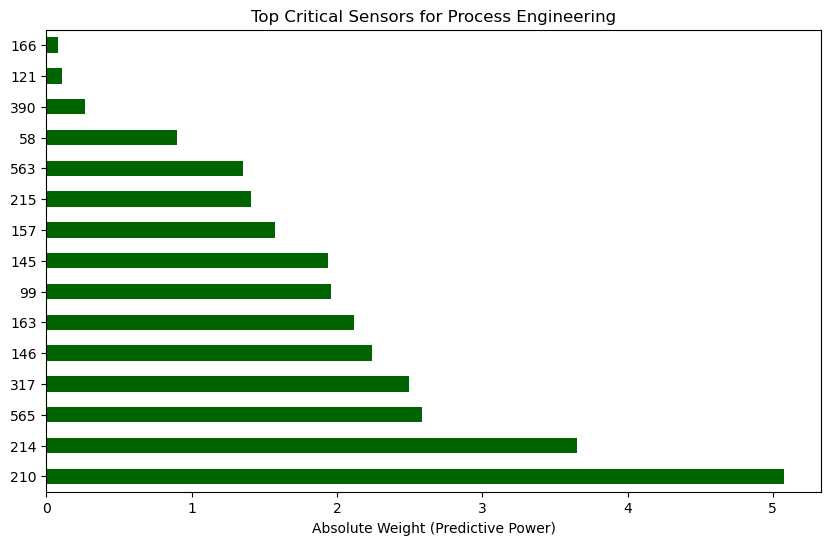

In [7]:
plt.figure(figsize=(10, 6))
importance.plot(kind='barh', color='darkgreen')
plt.title("Top Critical Sensors for Process Engineering")
plt.xlabel("Absolute Weight (Predictive Power)")
plt.show()

# Inter-sensor Redundancy

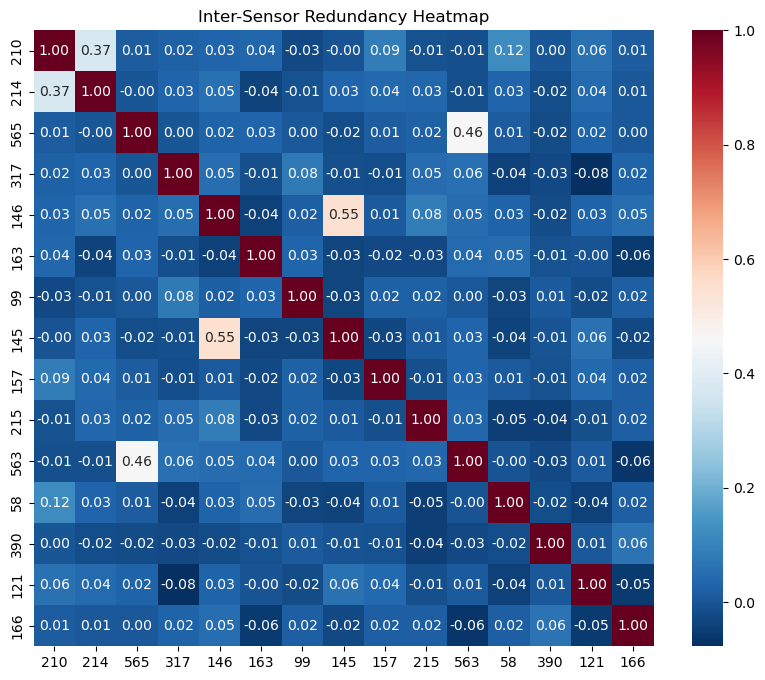

In [8]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[importance.index].corr(), annot=True, cmap='RdBu_r', fmt=".2f")
plt.title("Inter-Sensor Redundancy Heatmap")
plt.show()

# Top 5 features summary dashboard

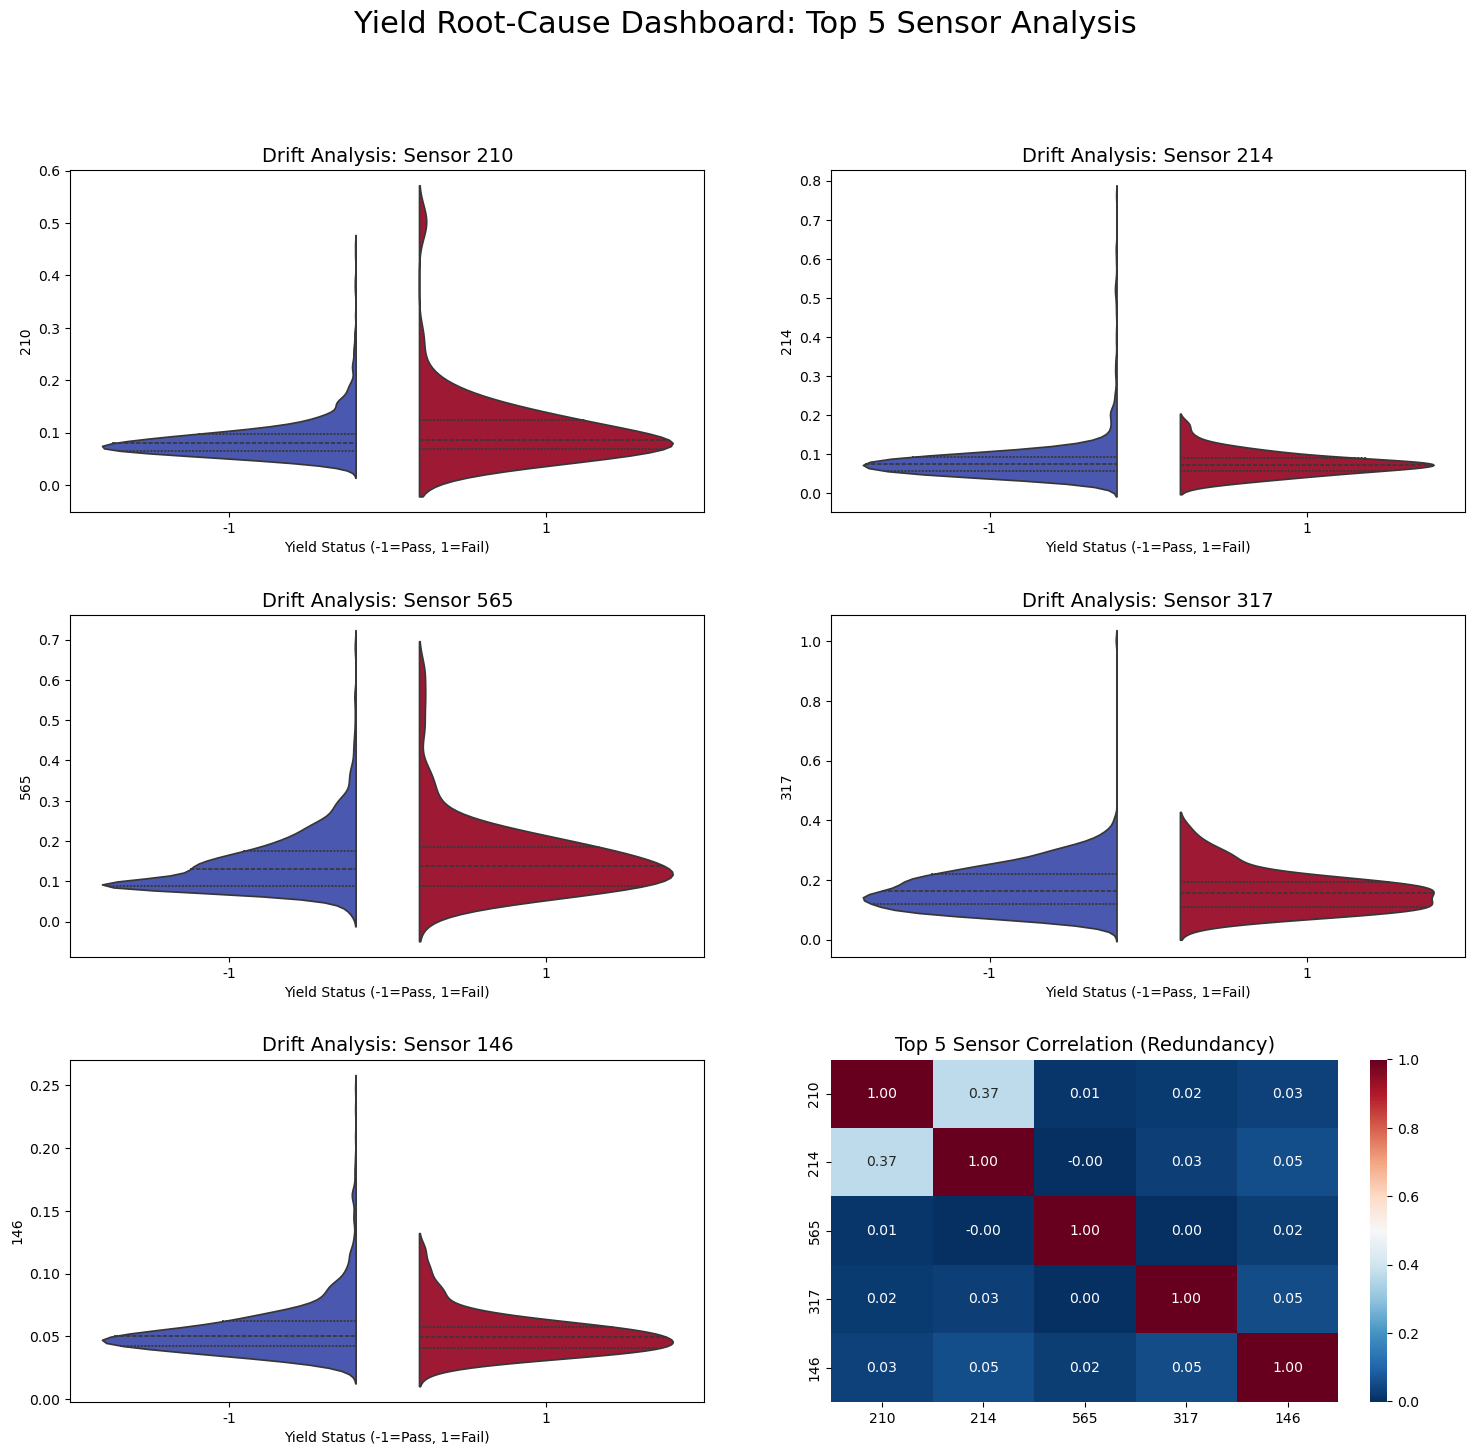

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Select the Top 5 Sensors based on Importance
top_5 = importance.index[:5].tolist()

# 2. Setup the Dashboard Grid (3 rows x 2 columns)
fig = plt.figure(figsize=(18, 16))
grid = plt.GridSpec(3, 2, hspace=0.3, wspace=0.2)
fig.suptitle('Yield Root-Cause Dashboard: Top 5 Sensor Analysis', fontsize=22)

# 3. TOP 5 DISTRIBUTION DRIFT (Violin Plots)
# These show how the signal shifts or spreads during a failure
for i, sensor in enumerate(top_5):
    ax = fig.add_subplot(grid[i // 2, i % 2])
    sns.violinplot(data=df, x='target', y=sensor, hue='target', 
                   ax=ax, palette='coolwarm', split=True, inner="quart", legend=False)
    ax.set_title(f'Drift Analysis: Sensor {sensor}', fontsize=14)
    ax.set_xlabel('Yield Status (-1=Pass, 1=Fail)')

# 4. REDUNDANCY AUDIT (Heatmap)
# Identifying if these top 5 sensors are independent or correlated
ax_heat = fig.add_subplot(grid[2, 1])
sns.heatmap(df[top_5].corr(), annot=True, cmap='RdBu_r', fmt=".2f", ax=ax_heat)
ax_heat.set_title('Top 5 Sensor Correlation (Redundancy)', fontsize=14)

plt.show()